# Logistic regression

## Introduction 

Pour ce projet, nous allons utiliser le jeu de données de test présent dans sklearn.datasets nommé `breast_cancer`.
Bien que le nombre d'echantillons ( seulement 569) n'est pas suffisant pour appliquer dans le monde réel un algorithme d'apprentissage des données, cela convient cependant pour illustrer  le concept. 


## Objectif : 
- Construire un modèle de regression logistique.
- Faire une prediction.

## Import packages

In [71]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

## Chargement des données

In [72]:
# On utilise return_X_y pour recuperer séparément les features (X), et la variable à prédire (y)
X,y = datasets.load_breast_cancer(return_X_y=True,as_frame=True)

In [73]:
X.shape

(569, 30)

Il y a 30 features pour ce jeu de données.

In [74]:
X[:5]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


* y = 1 si la personne est atteinte d'un cancer.
* y = 0 si elle ne l'ai pas.

In [75]:
y.describe()

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

Dans le jeu de données, plus de la moitié sont des données de personnes atteintes d'un cancer du sein.

In [76]:
X['mean symmetry']

0      0.2419
1      0.1812
2      0.2069
3      0.2597
4      0.1809
        ...  
564    0.1726
565    0.1752
566    0.1590
567    0.2397
568    0.1587
Name: mean symmetry, Length: 569, dtype: float64

## Visualisation des données

Parmi les 30 features présentes dans le dataset, on peut par exemple plot certains features pour mettre en avant la présence d'un pattern.
Ci-dessous sont des plots pris au hasard parmi ces features.

In [77]:
def scatter_plot(df, field1, field2, y, title):
    fig, ax = plt.subplots()
    for color in ['tab:blue', 'tab:orange']:
        n = 750
        mask = y == 1 if color == 'tab:blue' else y == 0
        label = 'Positif' if color == 'tab:blue' else 'Négatif'
        tmp_x = df[mask]
        tmp_y = y[mask]
        
        ax.scatter(tmp_x[field1].values, tmp_x[field2].values, c=color, label=label,
                alpha=0.3, edgecolors='none')

    ax.legend(title="Breast Cancer")
    ax.grid(True)
    ax.set(title=title)

    plt.show()
    
    

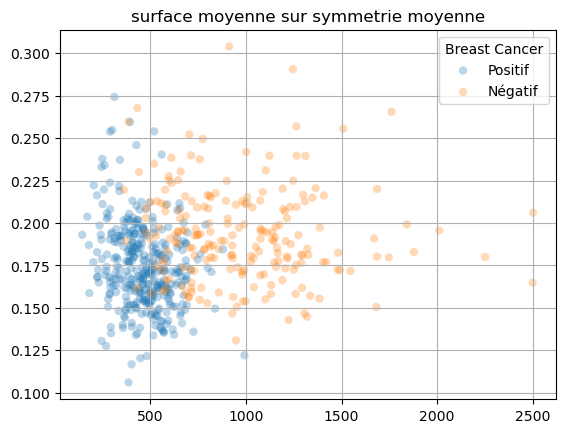

In [78]:
scatter_plot(X, 'mean area', 'mean symmetry', y, "surface moyenne sur symmetrie moyenne")


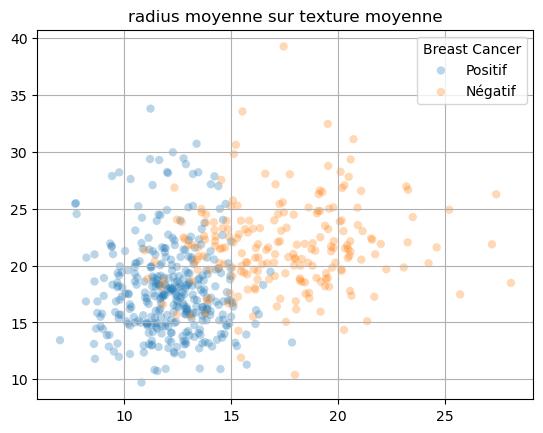

In [79]:
scatter_plot(X, 'mean radius', 'mean texture', y, "radius moyenne sur texture moyenne")


On remarque qu' il y a bien deux groupes distincs.
Pour avoir une vu d' ensemble des correlations entre les features, on va faire une heatmap.

<AxesSubplot:>

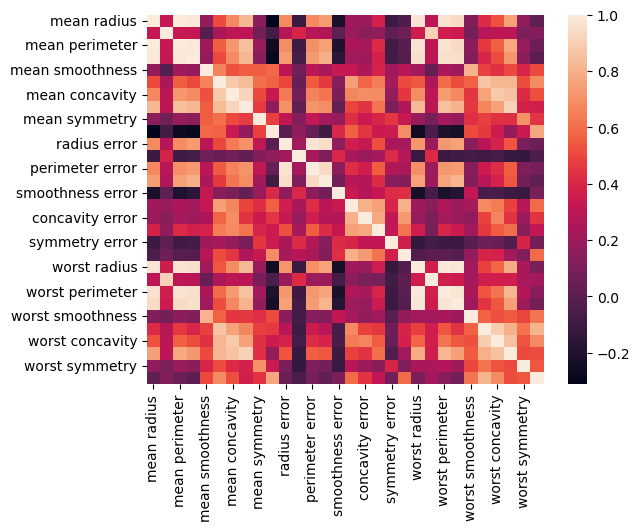

In [80]:
sns.heatmap(X.corr(), annot=False)

On voit par exemple que `symmetry error` et `mean perimeter` sont très peu correlées.
Le fait que deux features soient correlées ou non n'indique pas si elles  contribuent ou non pour la prediction de y.
Si deux variables sont tres fortement correlées, cela vaut le coup de supprimer l'une de deux pour la prediction, réduisant ainsi le nombre de features.

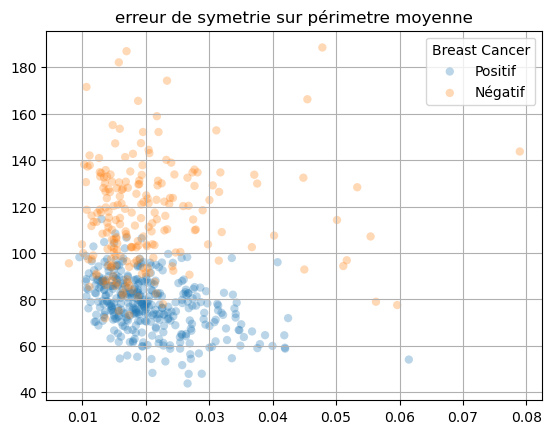

In [81]:
scatter_plot(X, 'symmetry error', 'mean perimeter', y, "erreur de symetrie sur périmetre moyenne")


Dans les parties suivantes, on va choisir une feature en essayant de predire la valeur.

## Creer les jeux d'entrainement et de test

Pour la suite du projet, on prépare le train set et le test set.

In [82]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True) 

In [83]:
print(f"train set size : {y_train.shape}, test set size : {y_test.shape}")

train set size : (426,), test set size : (143,)


## La fonction Sigmoide

Nous allons d'abord implémenter la fonction sigmoid, qui est la fonction pour la régression logistique.
La formule de la fonction sigmoid est : 
$$g(z) = \frac{1}{1+e^{-z}}$$
ou $$z = \mathbf{w} * \mathbf{x} + b$$


* L' interval de la fonction sigmoide est [ 0; 1].


In [84]:
def sigmoid(z):
    """Compute the sigmoid function

    Args:
        z (ndarray):A scalar, numpy array of any size

    Returns:
        g: sigmoid(z), with the same shape as z
    """
    #sigmoid formula
    t = np.exp(-z)
    g = 1 / (1 + np.exp(-z))
    return g

* Pour des larges valeurs positives de x, la fonction sigmoid est proche de 1.
* Pour des larges valeurs negatives de x, la fonction sigmoid est proche de 0.
* Pour une valeur de x de 0, la sigmoid est 0.5

In [85]:
val1 = 0
val2 = -500
val3 = 500

print(f"For {val1} --> {sigmoid(val1)},\nFor {val2} --> {sigmoid(val2)},\nFor {val3} --> {sigmoid(val3)}")

For 0 --> 0.5,
For -500 --> 7.124576406741285e-218,
For 500 --> 1.0


## Fonction de Coût pour la régression logistique

(cost function, loss function) 

Pour la régression logistique, la fonction de cout est définie ainsi:
$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

ou 
* m est le nombre de lignes dans le jeux d'entrainement ( training set).
* loss est la fonction de cout pour un unique point de données.
* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ est la prédiction du modèle (alors que $y^{(i)}$, est la valeur réelle).
    - C'est la fonction sigmoid, à laquelle on passe en paramèrre $z= x * w + b$

La fonction loss est définit ainsi:
$$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (l1 - l2)$$
ou 
$$l1 = -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)$$
$$l2 = (1 - y^{(i)}) \log(1 - f_{\mathbf{w},b}( \mathbf{x}^{(i)} ))$$





In [86]:
def compute_cost(X, y, w, b):
    """Cost function 

    Args:
        X (ndarray Shape(m,n)): data, m examples by n features
        y (ndarray Shape(m,)): target value
        w (ndarray Shape (n,) ): value of parameters of the model
        b (scalar): value of bias parameter of the model
    """
    m, n = X.shape
    total_cost = 0
    # Iterate all the examples
    for i in range(m):
        z = w.dot(X[i]) + b
        g = sigmoid(z)
        l1 = -y[i]*(np.log(g))
        l2 = -(1 - y[i])*np.log(1-g)
        loss = l1 - l2
        total_cost = total_cost + np.sum(loss)
        
    total_cost /= m
    return total_cost
        
        

On teste la fonction de cout sur le training set avec une configuration initiale. ( Simplement pour tester que la fonction marche correctement)
* **w** ( array des weights associés aux features) sont mis à zero.
* *b* (le biais) est aussi mis à zero 

In [87]:
# Nombre de features
nb_features = X_train.shape[1]
initial_w = np.zeros(nb_features) # chaque weight pour chaque feature mis a zéro
initial_b = 0. # Biais mis a zéro

# X et y attendu par compute_cost est une array2d, pas un dataframe
cost = compute_cost(X_train.values, y_train.values, initial_w, initial_b)
print(f"Cost with b = 0, and w = 0s : {cost}")

Cost with b = 0, and w = 0s : 0.18549009057237992


On peut varier les parametres **w** et *b*

In [88]:
initial_w = np.full((nb_features,), 0.0001, dtype=float) # chaque weight pour chaque feature 
initial_b = 0. # Biais mis a zéro

# X et y attendu par compute_cost est une array2d, pas un dataframe
cost = compute_cost(X_train.values, y_train.values, initial_w, initial_b)
print(f"Cost with b = 0, and w = 0s : {cost}")

Cost with b = 0, and w = 0s : 0.08953137576860352


## Descente de gradient pour la regression logistique


TODO : Ajouter explications

### Gradient
Pour calculer le gradient, on va calculer les dérivatives partieles:
$\frac{\partial J(\mathbf{w},b)}{\partial b}$,
$\frac{\partial J(\mathbf{w},b)}{\partial w_j}$

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)}
$$
ou 
$f_{\mathbf{w},b}(x^{(i)})$ est la prédiction du modèle, alors que $y^{(i)}$ est la valeur actuelle

In [89]:
def compute_gradient(X, y, w, b):
    # m = nombre de lignes
    # n = nombre de features
    m, n = X.shape
    # On calcule dj_dw : dérivative partielle de la fonction de cout par rapport à w
    # dj_db : d'erivative partielle par rapport à b
    dj_dw = np.zeros(w.shape)
    dj_db = 0
    
    # On fait pour toutes les lignes d'exemples
    for i in range(m):
        z_wb = w.dot(X[i]) + b
        f_wb =sigmoid(z_wb)
        
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        
        # dj_dw est une array de n features.
        # donc on calcule dj_dw pour chaque feature
        for j in range(n):
            dj_dw_ij = (f_wb - y[i])*(X[i,j])
            dj_dw[j] += dj_dw_ij
    dj_dw /= m
    dj_db /= m
    return dj_db, dj_dw

Verifions si la fonction 'compute_gradient' fonctionne correctement.

### Test avec initial_w = [0,...0], et initial_b = 0

In [90]:
initial_w = np.zeros(X_train.shape[1])
initial_b = 0.

# X_train et y_train sont des dataframes, donc on 
# donne en parametres la array contenue dans values.
dj_db, dj_dw = compute_gradient(X_train.values, y_train.values, initial_w, initial_b)
print(f'dj_db(0, 0) = {dj_db}')
print(f"dj_dw([0,...,0], 0) = \n{dj_dw.tolist()}")

dj_db(0, 0) = -0.13380281690140844
dj_dw([0,...,0], 0) = 
[-0.6108133802816902, -1.7152464788732398, -3.357887323943662, 36.687441314553986, -0.010660129107981222, 0.0011139319248826278, 0.01483728791079812, 0.008110926056338029, -0.019694131455399055, -0.008480528169014089, 0.025300704225352112, -0.1668659624413144, 0.18734882629107982, 7.219696009389671, -0.001024705399061033, -0.0008054600938967135, -0.0005758680751173711, -0.0003211431924882631, -0.0026863849765258207, -0.0003987922535211265, -0.32624882629107993, -2.1154225352112666, -1.3780985915492932, 88.0538732394365, -0.013471349765258217, 0.010612910798122063, 0.028997789906103272, 0.009816934272300456, -0.026441079812206576, -0.008505387323943667]


### Test avec initial_w = [0,...0], et initial_b = 0

In [91]:
initial_w = np.full((nb_features,), 0.0001, dtype=float) # chaque weight pour chaque feature
initial_b = 0.3

# X_train et y_train sont des dataframes, donc on 
# donne en parametres la array contenue dans values.
dj_db, dj_dw = compute_gradient(X_train.values, y_train.values, initial_w, initial_b)
print(f'dj_db(0, 0) = {dj_db}')
print(f"dj_dw([0,...,0], 0) = \n{dj_dw.tolist()}")

dj_db(0, 0) = -0.014940077438319802
dj_dw([0,...,0], 0) = 
[1.1528181973002938, 0.6225362788571877, 8.153050315817564, 123.248259073979, 0.0008279700121093418, 0.01409798220928569, 0.026588655447290895, 0.014647225983897798, 0.001826061400430756, -0.0010660181173466786, 0.07916947638552763, -0.020893067830034293, 0.5697602268836489, 13.033105926384243, -0.00020316888447650242, 0.0023440126872436478, 0.0033941302067249015, 0.0011293447843228677, -0.00024174711621303415, 5.735242624683653e-05, 1.7225970331695664, 0.9925034686556801, 12.172420442482194, 206.3831305021394, 0.0022689252205755584, 0.04246204059485138, 0.06381927511460084, 0.024493092841165645, 0.008188952199200948, 0.0014852189756701518]


Maintenant qu'on a la fonction `compute_gradient` implémentée, on peut faire la descente de gradient (gradient descent)

### Descente de gradient

Le but de la descente de gradient est de trouver les parametres optimaux pour le modèle de regression logistique.


In [92]:
def gradient_descent(X, y, w_initial, b_initial, learning_rate, num_iters):
    m = X.shape[0]
    
    # m : nombre de ligne d'exemples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    # On garde trace des couts J, et weights pour chaque iteration
    # Dans le but de pouvoir représenter le processus avec un graphique ensuite.
    J_history = []
    w_history = []
    
    for i in range(num_iters):
        # On calcule le gradient pour chaque iteration
        dj_db, dj_dw = compute_gradient(X, y, w_initial, b_initial)   

        # Mise a jour des params  avec w, b, alpha and gradient
        w_initial = w_initial - alpha * dj_dw               
        b_initial = b_initial - alpha * dj_db              
       
        if i<100000:
            cost =  compute_cost(X, y, w_initial, b_initial)
            J_history.append(cost)

        # On affiche le coût toutes les 10 iterations
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_initial)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_initial, b_initial, J_history, w_history

### Test de la descente de gradient

In [93]:
np.random.seed(1)
initial_w = 0.000001 * (np.random.rand(X_train.shape[1]) - 0.5)
initial_b = -0.0001

# Some gradient descent settings
iterations = 100
alpha = 0.00001

w,b, J_history,_ = gradient_descent(X_train.values ,
                                    y_train.values, 
                                    initial_w, 
                                    initial_b, 
                                    alpha,
                                    iterations)

Iteration    0: Cost     0.61   
Iteration   10: Cost     1.44   
Iteration   20: Cost     1.27   
Iteration   30: Cost     1.15   
Iteration   40: Cost     1.01   
Iteration   50: Cost     0.89   
Iteration   60: Cost     0.78   
Iteration   70: Cost     0.67   
Iteration   80: Cost     0.57   
Iteration   90: Cost     0.47   
Iteration   99: Cost    -0.16   


## Dessiner la frontière de décision

On ne peut pas dessiner la frontière de décision car on a trop de features pour le modèle ci-dessus.

Ici on va illustrer en faisant la procédure sur seulement deux features.

On va utiliser les parametres finaux de la descente de gradient pour dessiner l'ajustement linéaire (linear fit).

In [94]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.039870,0.03700,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.13850,0.12660,0.12420,0.09391,0.2827,0.06771
296,10.91,12.35,69.14,363.7,0.08518,0.04721,0.012360,0.01369,0.1449,0.06031,...,11.37,14.82,72.42,392.2,0.09312,0.07506,0.02884,0.03194,0.2143,0.06643
556,10.16,19.59,64.73,311.7,0.10030,0.07504,0.005025,0.01116,0.1791,0.06331,...,10.65,22.88,67.88,347.3,0.12650,0.12000,0.01005,0.02232,0.2262,0.06742
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.058620,0.04835,0.1495,0.05593,...,18.13,25.45,117.20,1009.0,0.13380,0.16790,0.16630,0.09123,0.2394,0.06469
468,17.60,23.33,119.00,980.5,0.09289,0.20040,0.213600,0.10020,0.1696,0.07369,...,21.57,28.87,143.60,1437.0,0.12070,0.47850,0.51650,0.19960,0.2301,0.12240


In [95]:
X_train_2features = X_train[['mean radius', 'mean texture']] 
X_train_2features.head()

,mean radius,mean texture
170,12.32,12.39
296,10.91,12.35
556,10.16,19.59
363,16.50,18.29
468,17.60,23.33


In [148]:
np.random.seed(1)
initial_w = 0.000001 * (np.random.rand(X_train_2features.shape[1]) - 0.5)
initial_b = 6

# Some gradient descent settings
iterations = 1000
alpha = 0.0020

w,b, J_history,_ = gradient_descent(
    X_train_2features.values, 
    y.values,
    initial_w,
    initial_b, 
    alpha, 
    iterations)

Iteration    0: Cost    -2.29   
Iteration  100: Cost    -0.16   
Iteration  200: Cost    -0.16   
Iteration  300: Cost    -0.16   
Iteration  400: Cost    -0.16   
Iteration  500: Cost    -0.16   
Iteration  600: Cost    -0.16   
Iteration  700: Cost    -0.16   
Iteration  800: Cost    -0.16   
Iteration  900: Cost    -0.16   
Iteration  999: Cost    -0.16   


In [97]:
w

array([-0.24803689, -0.33179904])

In [99]:
def plot_decision_boundary(df, field1, field2, y, title, w, b):
    fig, ax = plt.subplots()
    for color in ['tab:blue', 'tab:orange']:
        n = 750
        mask = y == 1 if color == 'tab:blue' else y == 0
        label = 'Positif' if color == 'tab:blue' else 'Négatif'
        tmp_x = df[mask]
        tmp_y = y[mask]
        
        ax.scatter(tmp_x[field1].values, tmp_x[field2].values, c=color, label=label,
                alpha=0.3, edgecolors='none')

    #TODO : Add decision boundary
    ax.legend(title="Breast Cancer")
    ax.grid(True)
    ax.set(title=title)

    plt.show()

In [117]:
 def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
 
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
    plot_data(X[:, 0:2], y)
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sigmoid(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

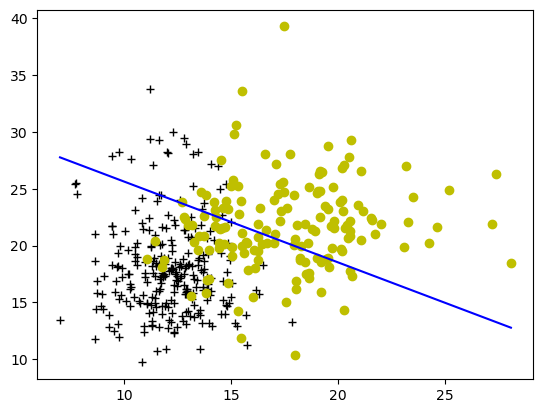

In [150]:
plot_decision_boundary(w, b, X_train_2features.values, y_train.values)

## Prediction et évaluation du modèle

On implémente ici la fonction de prédiction. Celle-ci prend en paramètres les w, et b optimisés grâce à la descente de gradient.

In [124]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # m : Nb of examples, n : Nb of features 
    m, n = X.shape   
    p = np.zeros(m)
   
    # Loop over each example
    for i in range(m):   
        z_wb = w.dot(X[i]) + b
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)
        # Apply the threshold
        p[i] = 1 if f_wb >= 0.5  else 0
    return p

Nous testons la prédiction sur le jeux d'entrainement

Dans un premier pour seulement 2 features, correspondant au diagramme avec la decision boundary

In [127]:
# Compute accuracy on our training set
p = predict(X_train_2features.values, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train.values) * 100))

Train Accuracy: 81.690141


Maintenant, on essaye avec toute les features.



In [146]:
np.random.seed(1)
initial_w = 0.000001 * (np.random.rand(X_train.shape[1]) - 0.5)
initial_b = 3

# Some gradient descent settings
iterations = 1000
alpha = 0.000001

w_all, b_all,  J_history,_ = gradient_descent(
    X_train.values, 
    y.values,
    initial_w,
    initial_b, 
    alpha, 
    iterations)

Iteration    0: Cost    -1.05   
Iteration  100: Cost    -0.36   
Iteration  200: Cost    -0.34   
Iteration  300: Cost    -0.32   
Iteration  400: Cost    -0.31   
Iteration  500: Cost    -0.30   
Iteration  600: Cost    -0.29   
Iteration  700: Cost    -0.28   
Iteration  800: Cost    -0.27   
Iteration  900: Cost    -0.26   
Iteration  999: Cost    -0.25   


In [147]:
# Compute accuracy on our training set
p = predict(X_train.values, w_all,b_all)
print('Train Accuracy: %f'%(np.mean(p == y_train.values) * 100))

Train Accuracy: 77.699531
